# Poulos et al, 2022

Dataset is available at [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD015912).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../../data/poulos2020"
DATA_PATH = os.path.join(DATA_DIR, "Peptide_intensity_matrix_b9369842-f3cf-4383-9e5c-6734dadcfbc9.csv")
ANNOTATION_PATH = os.path.join(DATA_DIR, "Mapping_file_PXD015912.xlsx")

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")
annotations = pd.read_excel(ANNOTATION_PATH, sheet_name="PXD015912")

In [4]:
var_cols = [c for c in data.columns if not c[0].isdigit()]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

In [5]:
data = data.T
data = np.log(data + 1)

In [6]:
obs = annotations.copy()

obs["name"] = obs["Filename"].str.lower()

obs = pd.merge(obs, pd.Series(data.index, name="name"), left_on="name", right_on="name")
obs.set_index("name", inplace=True)

In [7]:
obs.sort_index(inplace=True)
data.sort_index(inplace=True)

In [8]:
info = obs["Information"].str.split("_")

obs["day"] = [i[0] for i in info]
obs["method"] = [i[1] for i in info]
obs["sample"] = [i[2].split(".")[0] for i in info]

obs["ratio"] = [("_".join(i[2].split(".")[1:]))[1:] for i in info]

In [9]:
def get_ratio(raw):
    raw = raw.rstrip()
    raw = raw.lstrip()
    ratio = raw.split("%")[0]
    ratio = ratio.replace("_", ".")
    fratio = float(ratio) / 100
    return str(fratio)

obs["ovary"] = 0
obs["prostate"] = 0
obs["yeast"] = 0
obs["hek293t"] = 0

for i, row in obs.iterrows():
    ratio = row["ratio"]
    if ratio.startswith("HEK293T"):
        obs.loc[i, "hek293t"] = 1
    else:
        types = ratio.split("/")

        assert len(types) == 3

        assert "Ovary" in types[0]
        obs.loc[i, "ovary"] = get_ratio(types[0])
        
        assert "Prostate" in types[1]
        obs.loc[i, "prostate"] = get_ratio(types[1])

        assert "Yeast" in types[2]
        obs.loc[i, "yeast"] = get_ratio(types[2])

In [10]:
obs["control"] = (obs["hek293t"] == 1).astype(int)
obs["ovary"] = obs["ovary"].astype("category")
obs["prostate"] = obs["prostate"].astype("category")
obs["yeast"] = obs["yeast"].astype("category")

In [11]:
adata = sc.AnnData(X=data, obs=obs, var=vars)

adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

adata.layers["raw"] = adata.X.copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 1553 × 18114
    obs: 'Filename', 'Filetype', 'Information', 'day', 'method', 'sample', 'ratio', 'ovary', 'prostate', 'yeast', 'hek293t', 'control'
    var: 'Protein', 'Peptide', 'ModifiedPeptide'
    layers: 'raw'

In [13]:
print(f"nan intensities: {np.isnan(adata.layers['raw']).sum() / (adata.shape[0] * adata.shape[1]) * 100:.2f}%")

nan intensities: 45.52%


## Data Exploration

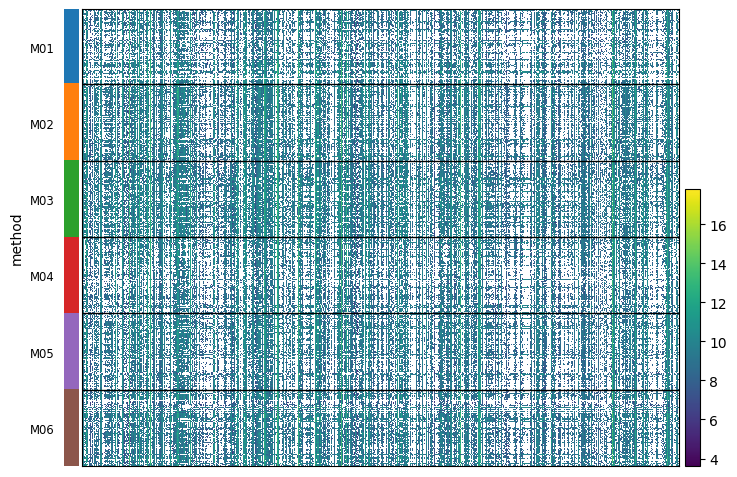

In [14]:
sc.pl.heatmap(adata, var_names=adata.var_names, groupby="method", show_gene_labels=False)

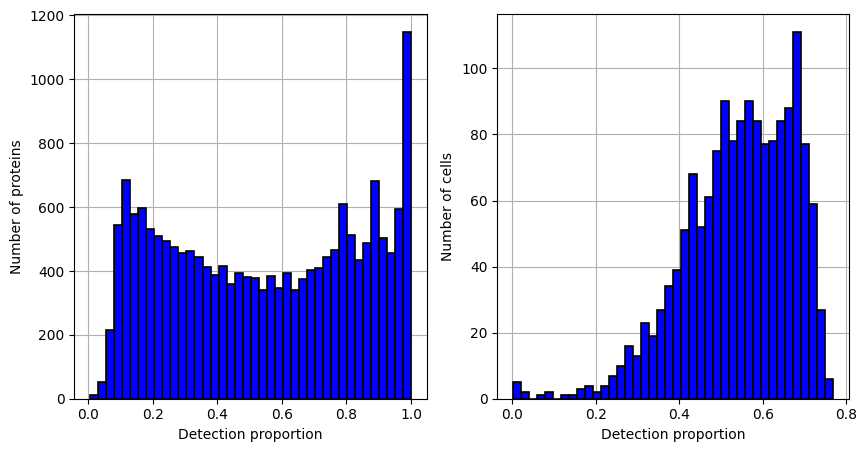

In [15]:
mask = np.isnan(adata.X)

p_protein = (~mask).mean(axis=0)
p_cell = (~mask).mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(p_protein, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(p_cell, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

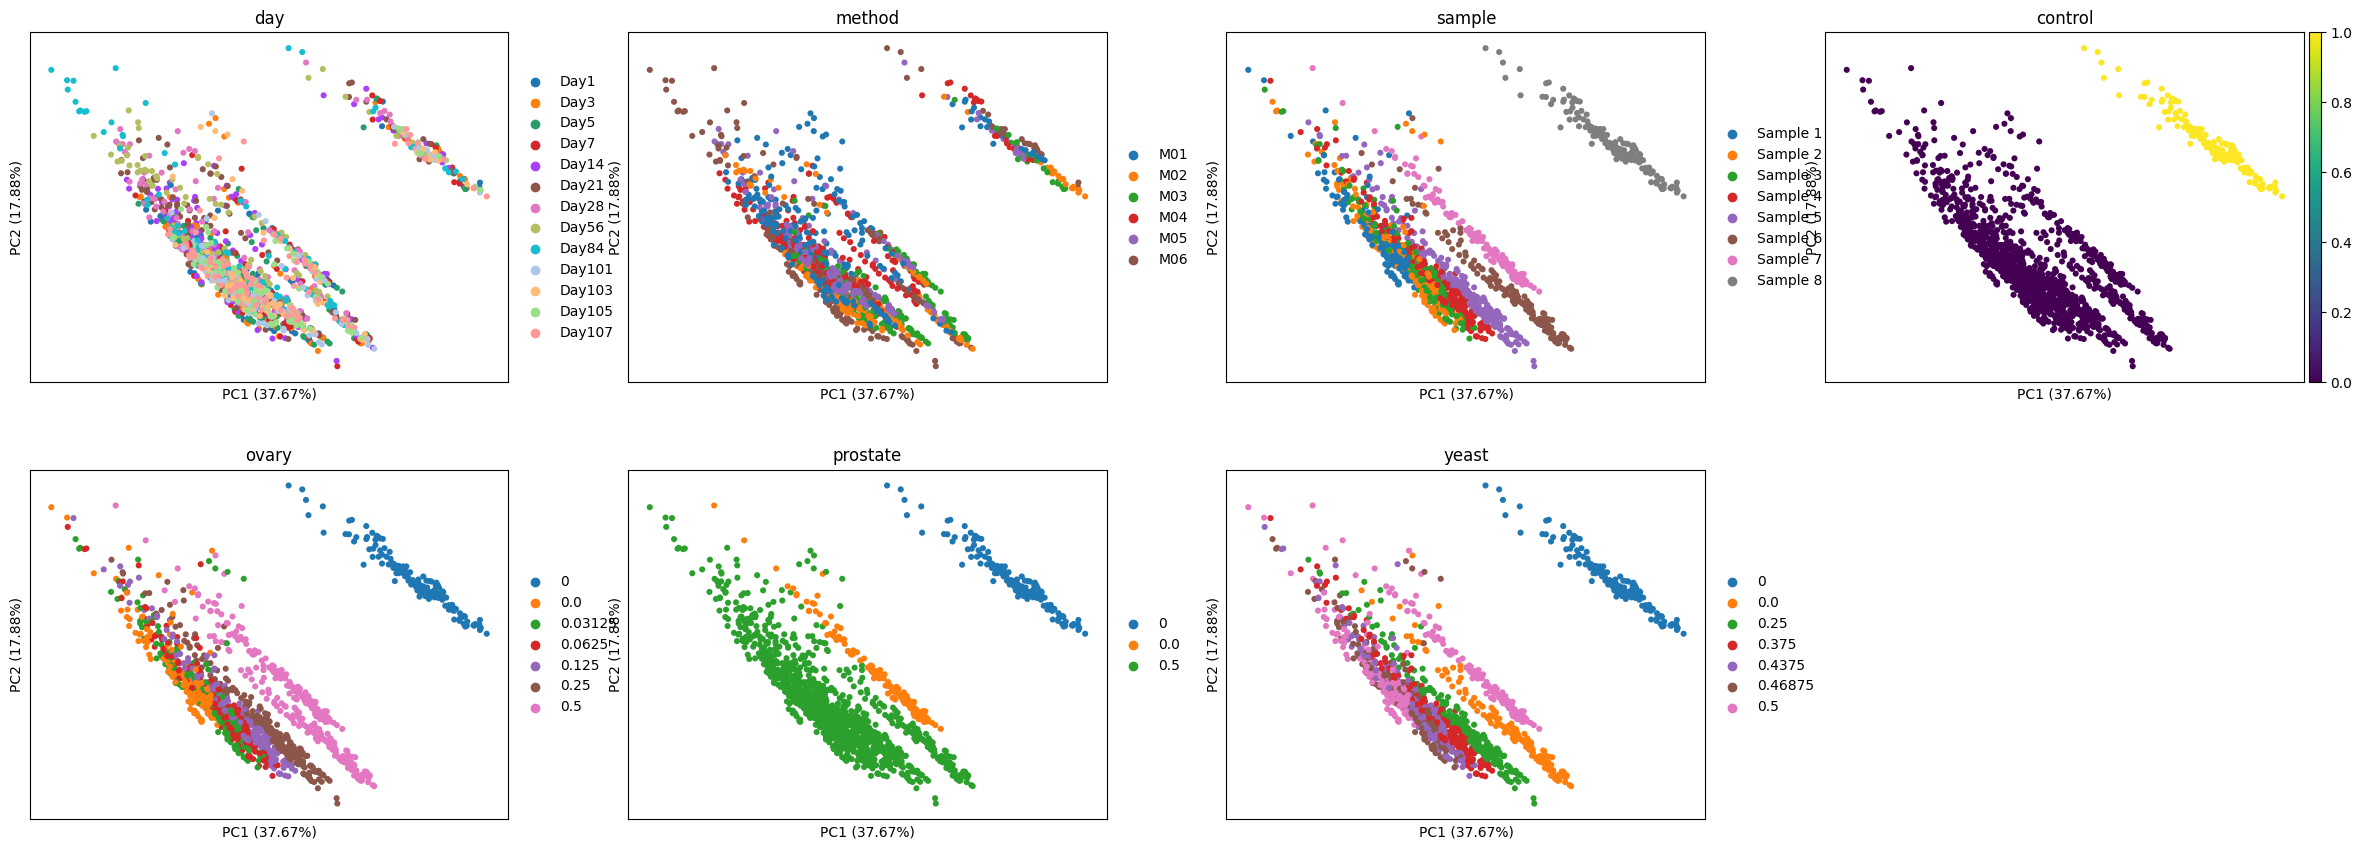

2023-11-27 12:10:57.958379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 12:10:57.958404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 12:10:57.958420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 12:10:58.618757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


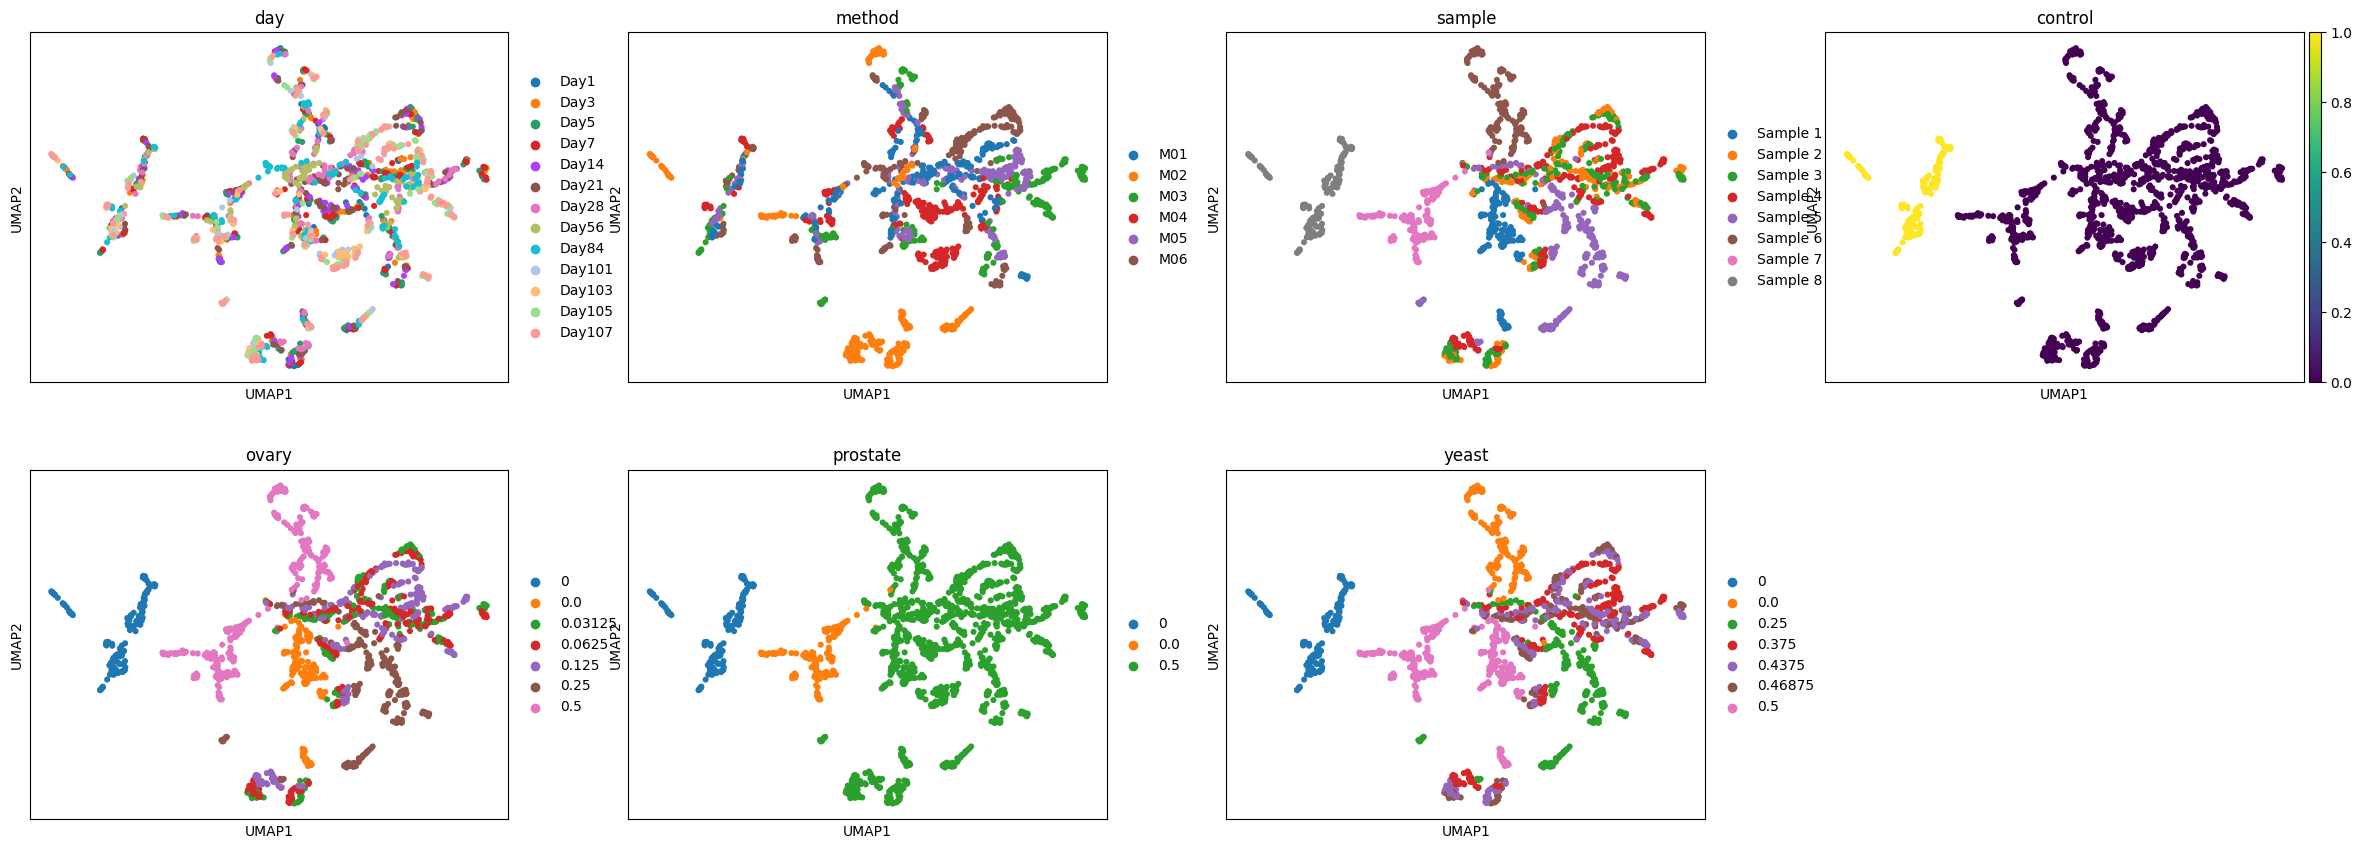

In [16]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)# remove control cells


sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
    components=["1,2"],
)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
)

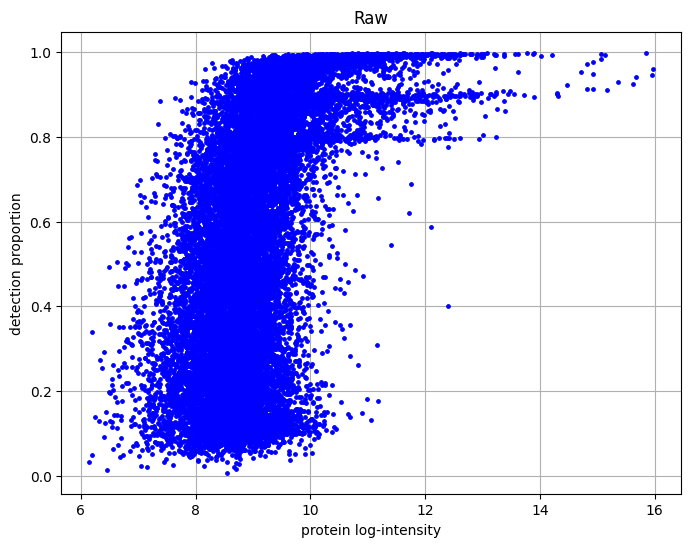

In [17]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="Raw")

/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/scp/plots.py:83: RuntimeWarning: Mean of empty slice
  x_obs_protein = np.nanmean(x, axis=0)


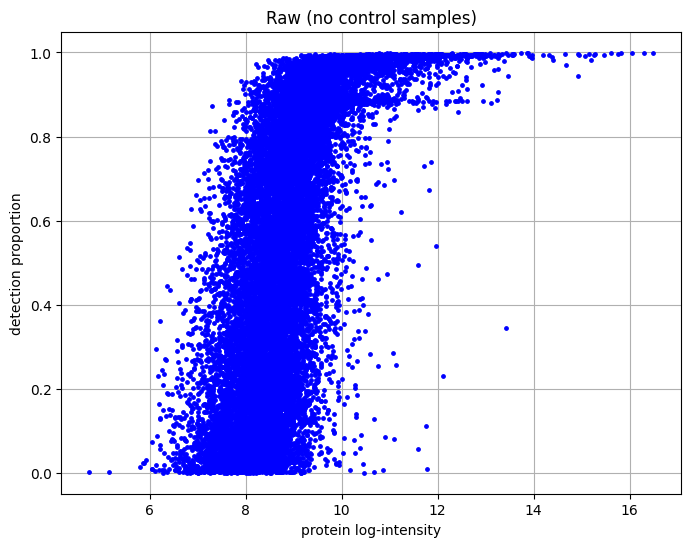

In [18]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"][adata.obs["control"] == 0,], title="Raw (no control samples)")

Remove control samples.

In [19]:
adata.X = adata.layers["raw"].copy()
adata = adata[adata.obs["control"] == 0,].copy()

adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

Filter proteins.

In [20]:
#peptides = np.random.choice(adata.shape[1], size=1000, replace=False)
#adata = adata[:, peptides].copy()

## PROTVI

### Training

Let's now train the model.

In [21]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [22]:
PROTVI.setup_anndata(adata)#, batch_key="method")

model = PROTVI(adata, log_variational=False, n_hidden=64, n_layers=1)
#model.view_anndata_setup()

Let's train the model.

In [23]:
model.train(max_epochs=2000, plan_kwargs={"mechanism_weight": 0}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2000/2000: 100%|██████████| 2000/2000 [40:57<00:00,  1.01it/s, v_num=1, train_loss_step=-455, train_loss_epoch=13.2]      

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [40:57<00:00,  1.23s/it, v_num=1, train_loss_step=-455, train_loss_epoch=13.2]


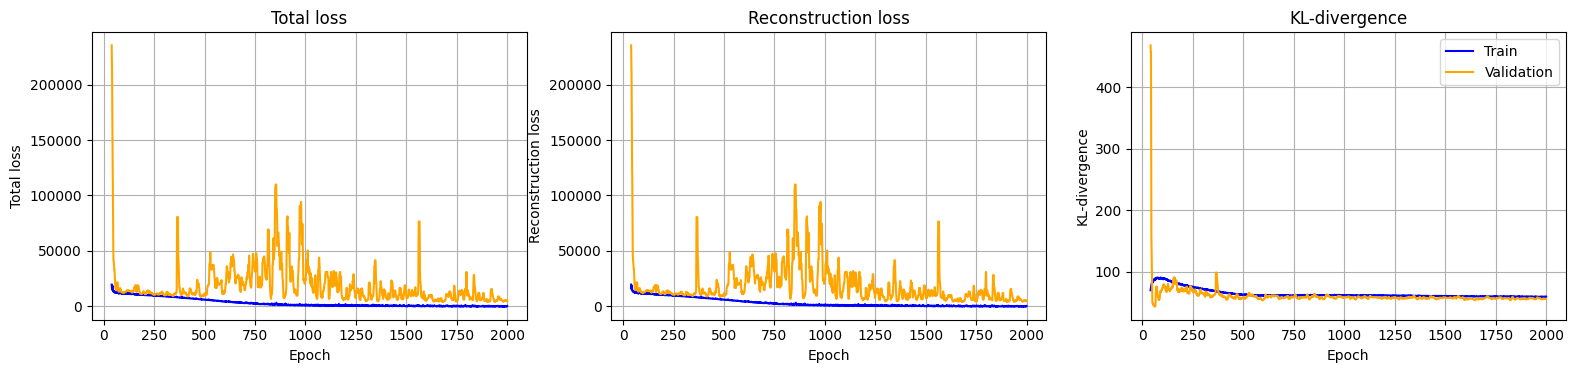

In [24]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

### Evaluation on training set

In [25]:
x_est, p_est = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

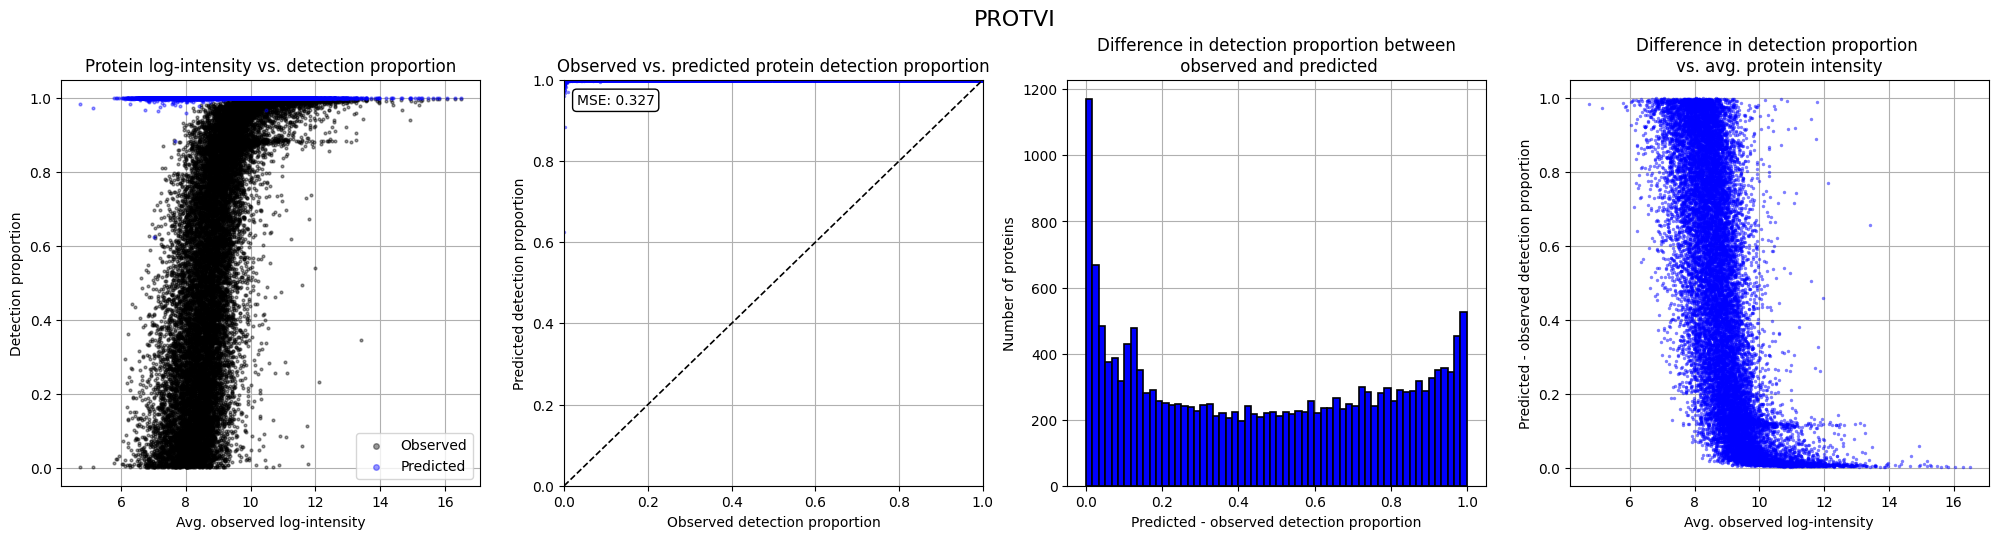

In [26]:
pl.plot_protein_detection_proportion_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

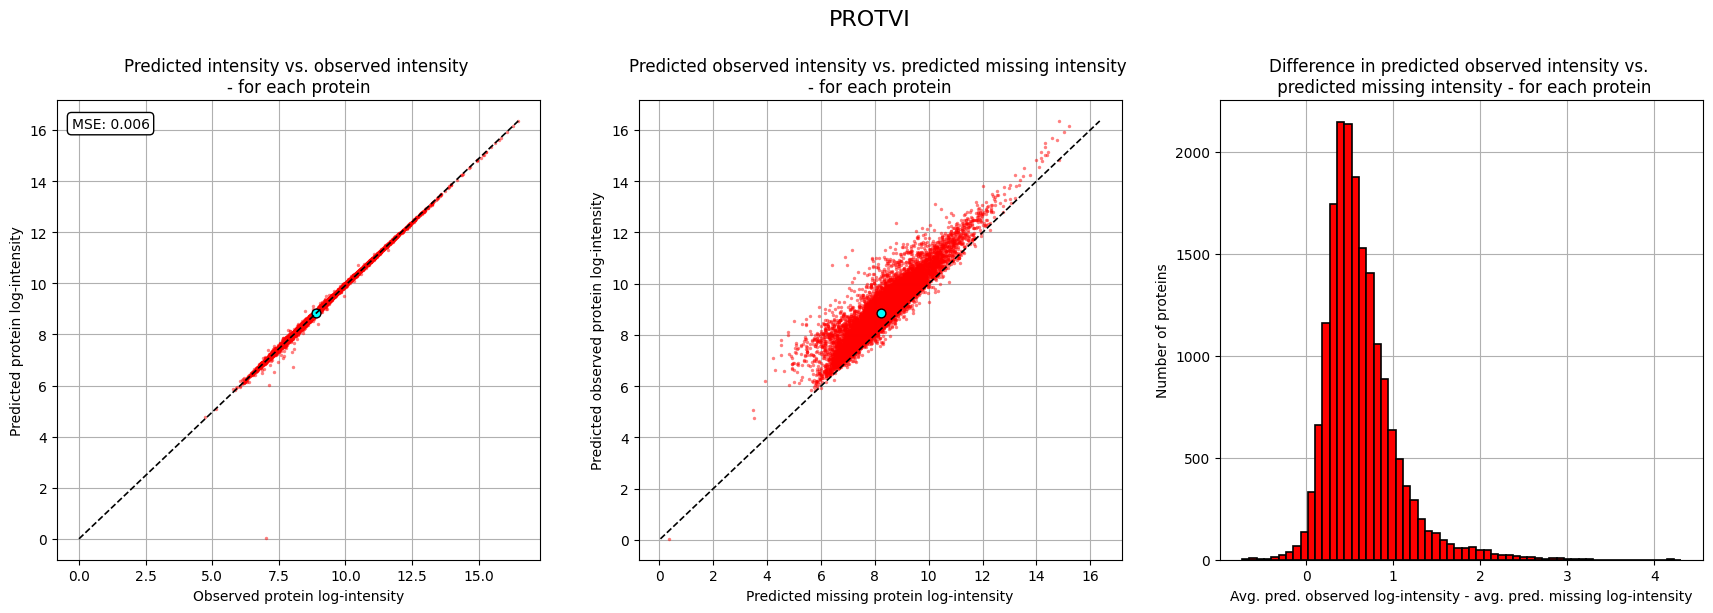

In [27]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [28]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

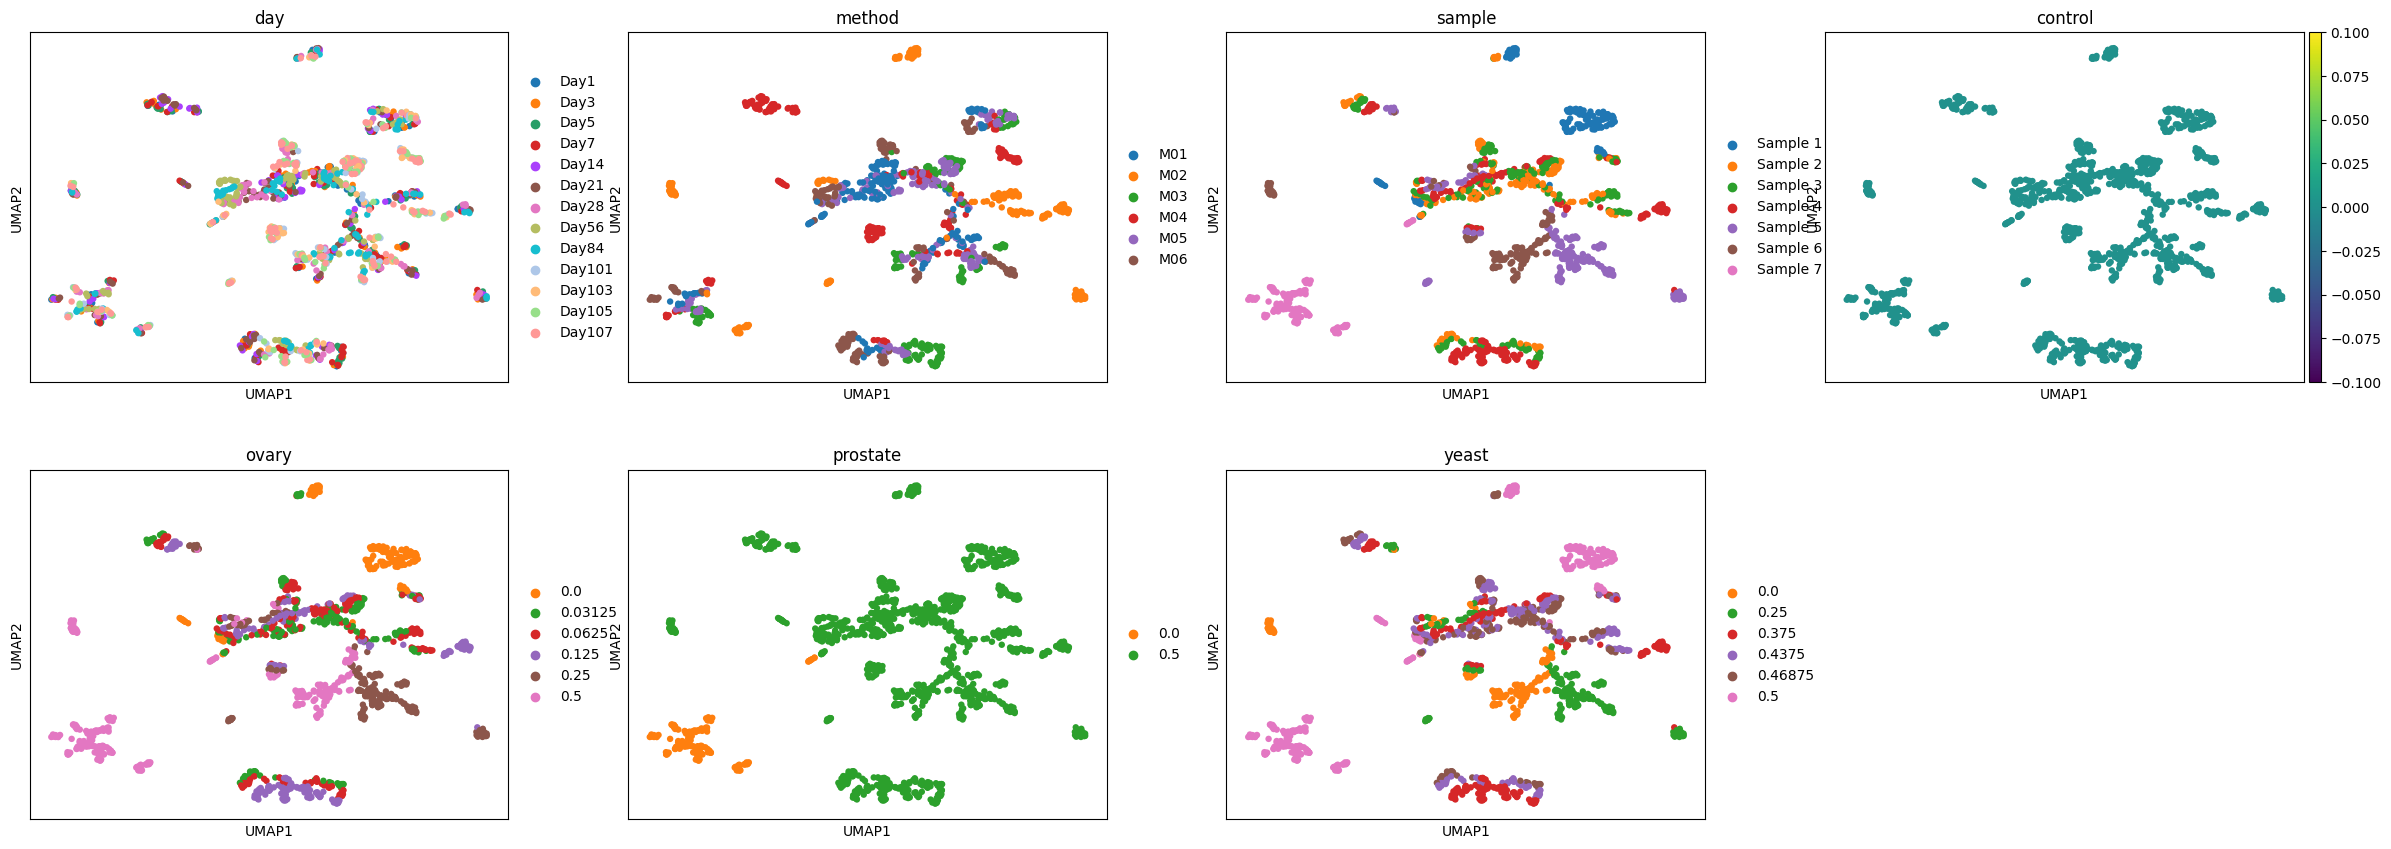

In [29]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

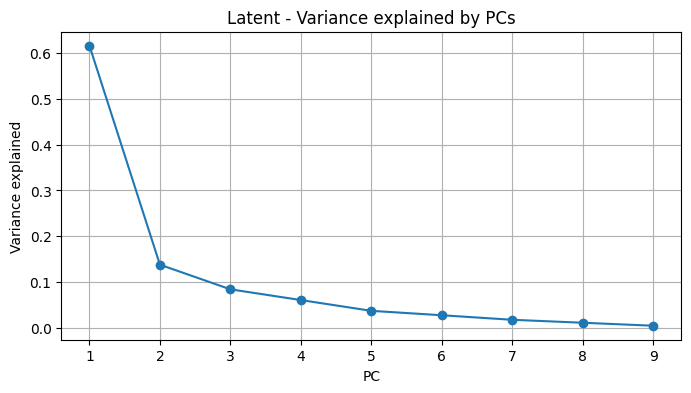

In [30]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

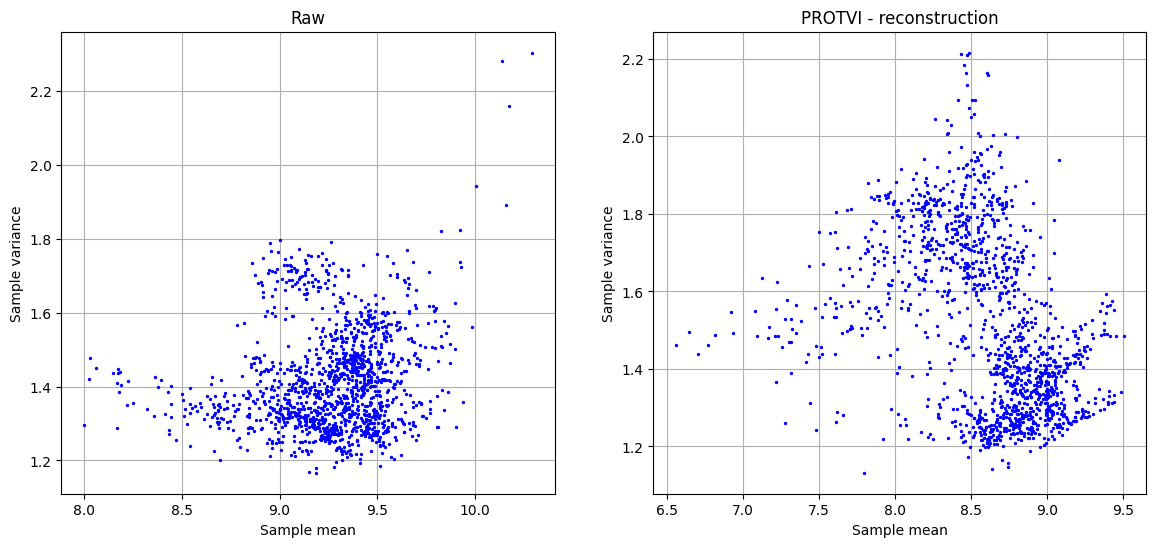

In [31]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["raw"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [32]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [33]:
r_adata = utils.prepare_anndata_for_R(adata)

In [34]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw")
dpcfit <- dpc(X)

In addition: Warning message:
Zero sample variances detected, have been offset away from zero 


In [35]:
protdp_result = robjects.r("dpcfit")

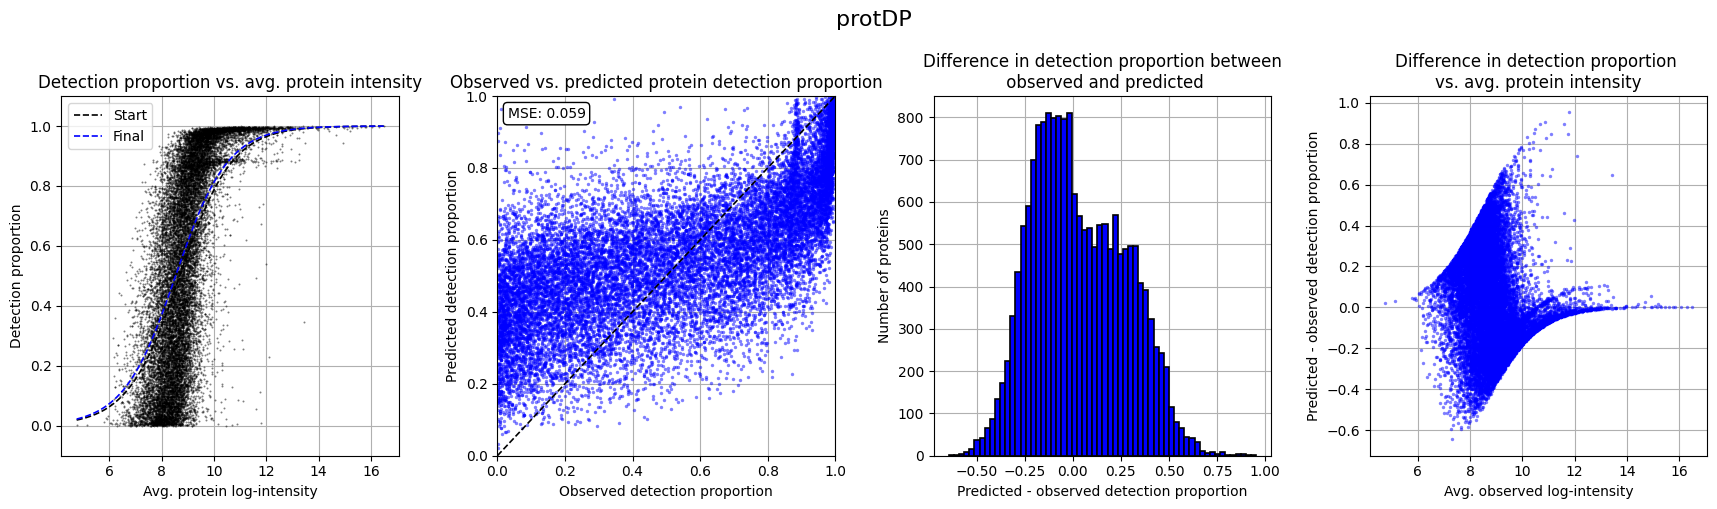

In [36]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

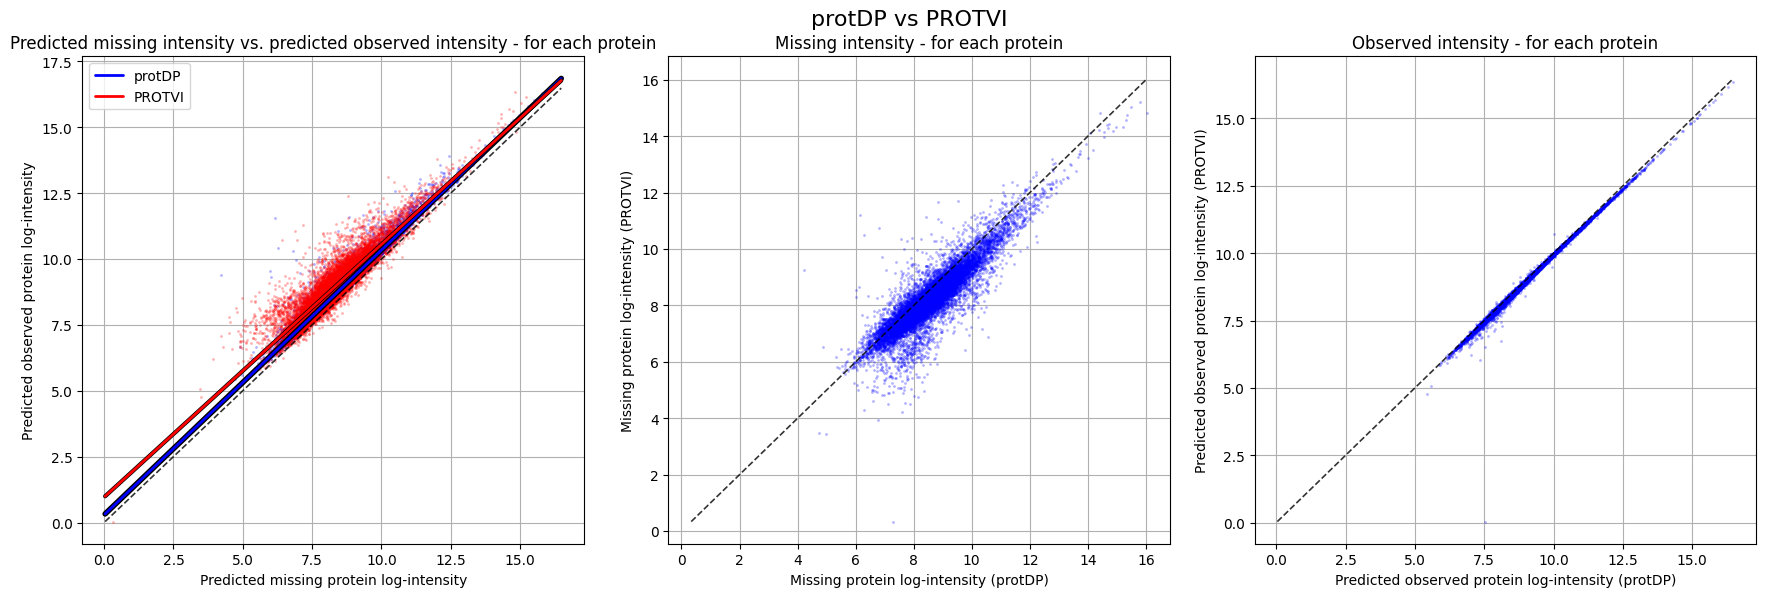

In [37]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

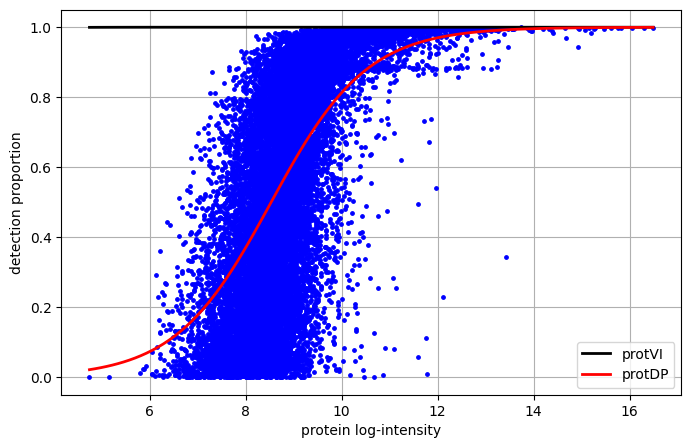

In [38]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()